In [19]:
import os, sys, random
import numpy as np
import matplotlib.pyplot as plt
import pylab
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import torch.utils.data 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torchviz import make_dot
from scipy.io import savemat



In [20]:
#New normalizer
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        self.mean = np.mean(x, axis=0)
        self.std = np.std(x, axis=0)
        self.eps = eps

    #Use this for normalization
    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    #Use this for denorm
    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        x = (x * std) + mean
        return x

In [21]:
def ani_frame(X, N_TIME_STEPS, name, dataset, min_val, max_val, percentile, norm=False, dpi=100):
    # Create a figure with a single subplot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #Same colorbar scale
    im = ax.imshow(X[5,:,:], origin='lower', interpolation='bicubic', cmap='jet')
    fig.colorbar(im)

    test = X[X!=0]
    print('mean/stddev', np.mean(test), np.std(test))
    
    if percentile:
        data_range = np.percentile(X, [2, 98])
        im.set_clim(data_range)
    else:
        im.set_clim([0, np.amax(X)])

    def update_img(n):
        tmp = X[n,:,:]
        im.set_data(tmp)
        return im

    ani = animation.FuncAnimation(fig, update_img, N_TIME_STEPS, interval=30)
    writer = animation.FFMpegWriter(fps=30)

    ani.save(dataset + 'cnn/' + name + '_demo.mp4', writer=writer, dpi=dpi)
    return ani

def getani(X, ns, dataset, which, min_val, max_val, percentile, norm=False):
    ani_frame(X, ns, which, dataset, min_val, max_val, False, norm)

    
def loaddata(dataset, var):
    varz = np.load(dataset + var + '.npz')
    var = np.transpose(varz['arr_0'], (2, 0, 1))
    return var

def getdata(dataset):
    variables = ['no', 'T', 'kPlanck','radVar1', 'radVar2', 'Delq']
    data = {}
    for i, var in enumerate(variables):
        data[var] = loaddata(dataset, var)
    return data

def organizedata(dataset,which):
    data = getdata(dataset+which)
    zdata = data

    ns = len(data['no'][:, 0, 0])
    nps = len(data['no'][0, :, 0])

    print("number of time steps, ns: ", ns)
    print("number pixels, nps: ", nps)
    print("max no", np.amax(data['no']))
    print("max T", np.amax(data['T']))
    print("max radVar1", np.amax(data['radVar1']))
    print("max radVar2", np.amax(data['radVar2']))

    # normalized variables
    #X as in the example
    norm_input_vars = getnorm(data,'inputs')

    #Y as in the example
    norm_target_vars = getnorm(data,'targets')

    # Define a list of normalized input variables
    input_vars = [ norm_input_vars[var] for var in norm_input_vars ]
    # for var in norm_input_vars:
    #     input_vars.append(norm_input_vars[var])

    # Define a list of normalized target variables
    target_vars = [ norm_target_vars[var] for var in norm_target_vars ]
    # for var in norm_target_vars:
    #     target_vars.append(norm_target_vars[var])

    # Stack the input and target variables into arrays
    inputs = np.stack(input_vars, axis=1)
    targets = np.stack(target_vars, axis=1)
    return inputs, targets, zdata, norm_input_vars, norm_target_vars

def getnorm(data, which):
    if which == 'targets':
        targets = {}
        for var in ['radVar1', 'radVar2']:
            targets[var] = normalize(data[var], which)
        return targets
    elif which == 'inputs':
        inputs = {}
        for var in ['no', 'T']:
            inputs[var] = normalize(data[var], which)
        return inputs
    else:
        normalized_data = {}
        for var in data:
            normalized_data[var] = normalize(data[var], which)
        return normalized_data

# def transform(A, which):
#     Amax = np.amax(A)
#     Amin = np.amin(A)
#     Range = Amax - Amin

#     if which == 'ilal': 
#         # inverse logit after log
#         var = A / (1 + A)
#     elif which == 'silal':
#         # square inverse logit after log
#         var = A * A / (1 + A * A)
#     elif which == 'exp':
#         # exponential
#         var = 1 - np.exp(A)
#     elif which == 'norm':
#         # norm 0 to 1
#         var = (A - Amin) / Range
#     elif which == 'log':
#         A_adjusted = A + 1e-10
#         var = np.log(A_adjusted)

#     return var

# def detransform(A, zA, which):
#     Amax = np.amax(zA)
#     Amin = np.amin(zA)
#     Range = Amax - Amin
#     print('mix/max original', Amin, Amax)
#     print('min/max transformed', np.amin(A), np.amax(A))

#     if which == 'ilal':
#         # inverse logit after log
#         var = A * (1 + zA)
#     elif which == 'silal':
#         # square inverse logit after log
#         var = np.sqrt(A * A * (1 + zA * zA))
#     elif which == 'exp':
#         # exponential
#         var = A + np.exp(zA) - 1
#     elif which == 'norm':
#         # norm 0 to 1
#         var = A * Range + Amin
#     elif which == 'log':
#         var = np.exp(zA) - 1e-10
#     print('min/max detransformed',np.amin(var),np.amax(var))
#     return var 

def normalize(A,which):
    # if which == 'targets':
    #     Anrm = transform(A,'log') 
    # else:
    #     Anrm = transform(A,'log')
    data_norm = UnitGaussianNormalizer(A)
    Anrm = data_norm.encode(A)
    return Anrm

def denormalize(A, zA, which):
    # if which == 'targets':
        # Adnrm = detransform(A, zA, 'log')
    # else:
    #     Adnrm = detransform(A, zA, 'log')
    
    Amax = np.amax(zA)
    Amin = np.amin(zA)
    Range = Amax - Amin
    print('mix/max original', Amin, Amax)
    print('min/max transformed', np.amin(A), np.amax(A))

    #Sets mean to already normalized data
    data_denorm = UnitGaussianNormalizer(zA)
    Adnrm = data_denorm.decode(zA)
    return Adnrm

def getdenorm(zdata, data, which):
    if which == 'targets':
        denorm_data = {}
        for var in ['radVar1', 'radVar2']:
            denorm_data[var] = denormalize(zdata[var], data[var], which)
        return denorm_data
    elif which == 'inputs':
        denorm_data = {}
        for var in ['no', 'T']:
            denorm_data[var] = denormalize(zdata[var], data[var], which)
        return denorm_data
    else:
        denorm_data = {}
        for var in zdata:
            denorm_data[var] = denormalize(zdata[var], data[var], which)
        return denorm_data



def showSbs(inputs, targets, i):
    f, ax = plt.subplots(2, 2)
    f.tight_layout()
    [axi.set_axis_off() for axi in ax.ravel()]
    
    data = [(inputs[i, 0, :, :], 'Input 1'), (inputs[i, 1, :, :], 'Input 2'),
            (targets[i, 0, :, :], 'Target 1'), (targets[i, 1, :, :], 'Target 2')]
    
    for axi, (data, label) in zip(ax.ravel(), data):
        im = axi.imshow(data, origin='lower', cmap='jet')
        im.set_clim([0, np.amax(data)])
        axi.set_title(label)
    
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax)
    
    

In [22]:
# dataset = 'd300s50/'
# dataset = 'd300s50na/'
dataset = 'd300s200/'
inputs, targets, zdata, norm_input_vars, norm_target_vars = organizedata(dataset,'train/')
ns = len(zdata['no'][:, 0, 0])
nps = len(zdata['no'][0, :, 0])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.20, random_state=42, shuffle=True)

# Assign the training and test sets to new variables
inputs = X_train
targets = y_train
vinputs = X_test
vtargets = y_test

print("Loaded data, {} training, {} validation samples".format(len(inputs),len(vinputs)))
print("Loaded data, {} targets, {} validation targets".format(len(targets),len(vtargets)))
print("Size of the inputs array: "+format(inputs.shape))
print("Size of the targets array: "+format(vtargets.shape))
print("Size of the vinputs array: "+format(vinputs.shape))
print("Size of the targets array: "+format(targets.shape))

# showSbs(inputs,targets,3)

number of time steps, ns:  300
number pixels, nps:  128
max no 0.34538015723228455
max T 4099.181640625
max radVar1 42618.44138049999
max radVar2 215035.618752
Loaded data, 240 training, 60 validation samples
Loaded data, 240 targets, 60 validation targets
Size of the inputs array: (240, 2, 128, 128)
Size of the targets array: (60, 2, 128, 128)
Size of the vinputs array: (60, 2, 128, 128)
Size of the targets array: (240, 2, 128, 128)


In [23]:
import operator
from functools import reduce

def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size()))
    return c

In [24]:
# global training constants
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 20
LR = 0.005

class DfpDataset():
    def __init__(self, inputs,targets): 
        self.inputs  = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

tdata = DfpDataset(inputs,targets)
vdata = DfpDataset(vinputs,vtargets)

trainLoader = torch.utils.data.DataLoader(tdata, batch_size=BATCH_SIZE, shuffle=True , drop_last=True) 
valiLoader  = torch.utils.data.DataLoader(vdata, batch_size=BATCH_SIZE, shuffle=False, drop_last=True) 

print("Training & validation batches: {} , {}".format(len(trainLoader),len(valiLoader) ))

def blockUNet(in_c, out_c, name, size=4, pad=1, transposed=False, bn=True, activation=True, relu=True, dropout=0. ):
    block = nn.Sequential()

    if not transposed:
        block.add_module('%s_conv' % name, nn.Conv2d(in_c, out_c, kernel_size=size, stride=2, padding=pad, bias=True))
    else:
        block.add_module('%s_upsam' % name, nn.Upsample(scale_factor=2, mode='bilinear'))
        # reduce kernel size by one for the upsampling (ie decoder part)
        block.add_module('%s_tconv' % name, nn.Conv2d(in_c, out_c, kernel_size=(size-1), stride=1, padding=pad, bias=True))

    if bn:
        block.add_module('%s_bn' % name, nn.BatchNorm2d(out_c))
    if dropout>0.:
        block.add_module('%s_dropout' % name, nn.Dropout2d( dropout, inplace=True))

    if activation:
        if relu:
            block.add_module('%s_relu' % name, nn.ReLU(inplace=True))
        else:
            block.add_module('%s_leakyrelu' % name, nn.LeakyReLU(0.2, inplace=True))

    return block
    
class DfpNet(nn.Module):
    def __init__(self, channelExponent=6, dropout=0.):
        super(DfpNet, self).__init__()
        channels = int(2 ** channelExponent + 0.5)
        InNum = 2
        self.layer1 = blockUNet(InNum     , channels*1, 'enc_layer1', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer2 = blockUNet(channels  , channels*2, 'enc_layer2', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer3 = blockUNet(channels*2, channels*2, 'enc_layer3', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer4 = blockUNet(channels*2, channels*4, 'enc_layer4', transposed=False, bn=True, relu=False, dropout=dropout )
        self.layer5 = blockUNet(channels*4, channels*8, 'enc_layer5', transposed=False, bn=True, relu=False, dropout=dropout ) 
        self.layer6 = blockUNet(channels*8, channels*8, 'enc_layer6', transposed=False, bn=True, relu=False, dropout=dropout , size=2,pad=0)
        self.layer7 = blockUNet(channels*8, channels*8, 'enc_layer7', transposed=False, bn=True, relu=False, dropout=dropout , size=2,pad=0)
     
        # note, kernel size is internally reduced by one for the decoder part
        self.dlayer7 = blockUNet(channels*8, channels*8, 'dec_layer7', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer6 = blockUNet(channels*16,channels*8, 'dec_layer6', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer5 = blockUNet(channels*16,channels*4, 'dec_layer5', transposed=True, bn=True, relu=True, dropout=dropout ) 
        self.dlayer4 = blockUNet(channels*8, channels*2, 'dec_layer4', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer3 = blockUNet(channels*4, channels*2, 'dec_layer3', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer2 = blockUNet(channels*4, channels  , 'dec_layer2', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer1 = blockUNet(channels*2, InNum     , 'dec_layer1', transposed=True, bn=False, activation=False, dropout=dropout )

    def forward(self, x):
        # note, this Unet stack could be allocated with a loop, of course... 
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        out7 = self.layer7(out6)
        # ... bottleneck ...
        dout6 = self.dlayer7(out7)
        dout6_out6 = torch.cat([dout6, out6], 1)
        dout6 = self.dlayer6(dout6_out6)
        dout6_out5 = torch.cat([dout6, out5], 1)
        dout5 = self.dlayer5(dout6_out5)
        dout5_out4 = torch.cat([dout5, out4], 1)
        dout4 = self.dlayer4(dout5_out4)
        dout4_out3 = torch.cat([dout4, out3], 1)
        dout3 = self.dlayer3(dout4_out3)
        dout3_out2 = torch.cat([dout3, out2], 1)
        dout2 = self.dlayer2(dout3_out2)
        dout2_out1 = torch.cat([dout2, out1], 1)
        dout1 = self.dlayer1(dout2_out1)
        return dout1

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
# channel exponent to control network size
EXPO = 2

# setup network
net = DfpNet(channelExponent=EXPO).to(device)
nn_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in nn_parameters])

print("Trainable params: {}  ".format(count_params(net)))

net.apply(weights_init)
criterionL1 = nn.L1Loss()
optimizerG = optim.Adam(net.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=1e-4)

targets = torch.autograd.Variable(torch.FloatTensor(BATCH_SIZE, 2, 128, 128)).to(device)
inputs  = torch.autograd.Variable(torch.FloatTensor(BATCH_SIZE, 2, 128, 128)).to(device)


history_L1 = []
history_L1val = []

if os.path.isfile(dataset+'networkk'):
  print("Found existing network, loading & skipping training")
  net.load_state_dict(torch.load(dataset+'network')) # optionally, load existing network

else:
  print("Training from scratch")
  for epoch in range(EPOCHS):
      net.train()
      L1_accum = 0.0
      for i, traindata in enumerate(trainLoader, 0):
          inputs_curr, targets_curr = traindata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          net.zero_grad()
          gen_out = net(inputs)

          lossL1 = criterionL1(gen_out, targets)
          lossL1.backward()
          optimizerG.step()
          L1_accum += lossL1.item()

      # validation
      net.eval()
      L1val_accum = 0.0
      for i, validata in enumerate(valiLoader, 0):
          inputs_curr, targets_curr = validata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          outputs = net(inputs)
          outputs_curr = outputs.data.cpu().numpy()

          lossL1val = criterionL1(outputs, targets)
          L1val_accum += lossL1val.item()

      # data for graph plotting
      history_L1.append( L1_accum / len(trainLoader) )
      history_L1val.append( L1val_accum / len(valiLoader) )

      if epoch<3 or epoch%20==0:
          print( "Epoch: {}, L1 train: {:7.5f}, L1 vali: {:7.5f}".format(epoch, history_L1[-1], history_L1val[-1]) )

  torch.save(net.state_dict(), dataset+'network' )
  print("Training done, saved network")

Training & validation batches: 12 , 3
Trainable params: 37258  
Training from scratch
Epoch: 0, L1 train: 0.34845, L1 vali: 0.36953
Epoch: 1, L1 train: 0.24811, L1 vali: 0.29534
Epoch: 2, L1 train: 0.20418, L1 vali: 0.19470
Epoch: 20, L1 train: 0.15793, L1 vali: 0.17080
Epoch: 40, L1 train: 0.14832, L1 vali: 0.13883
Epoch: 60, L1 train: 0.15029, L1 vali: 0.19460
Epoch: 80, L1 train: 0.14656, L1 vali: 0.12782
Training done, saved network


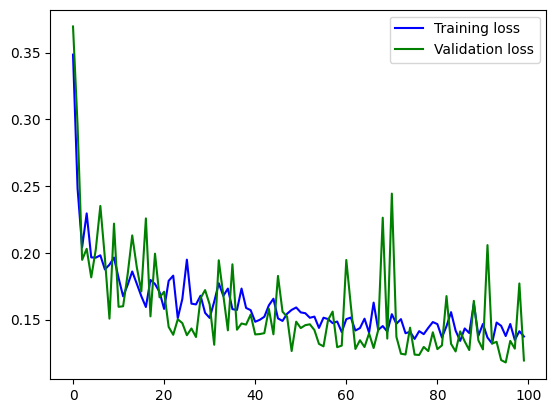

In [25]:

l1train = np.asarray(history_L1)
l1vali  = np.asarray(history_L1val)

plt.plot(np.arange(l1train.shape[0]),l1train,'b',label='Training loss')
plt.plot(np.arange(l1vali.shape[0] ),l1vali ,'g',label='Validation loss')
plt.legend()
plt.show()

In [26]:
net.eval()
for i, validata in enumerate(valiLoader, 0):
    inputs_curr, targets_curr = validata
    
    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()
    #if i<1: showSbs(targets_curr , outputs_curr,i)

In [27]:
# Test on new distribution

testinputs, testtargets, zdatand, norm_input_vars_nd, norm_target_vars_nd = organizedata(dataset,'test/')

testdata = DfpDataset(testinputs,testtargets)
testLoader  = torch.utils.data.DataLoader(testdata, batch_size=1, shuffle=False, drop_last=True) 

test_results = {"radVar1": np.zeros((ns,nps,nps)),"radVar2": np.zeros((ns,nps,nps))}

net.eval()
L1t_accum = 0.

for i, validata in enumerate(testLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())

    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()
    o = outputs_curr[0]
    test_results["radVar1"][i,:,:] = o[0,:,:]
    test_results["radVar2"][i,:,:] = o[1,:,:]
    lossL1t = criterionL1(outputs, targets)
    L1t_accum += lossL1t.item()
    #if i%100 ==0: showSbs(targets_curr,outputs_curr,0)

print("\nAverage test error: {}".format( L1t_accum/len(testLoader) ))

number of time steps, ns:  300
number pixels, nps:  128
max no 0.26989731192588806
max T 3268.87060546875
max radVar1 2376.98621242
max radVar2 260162.20421799997

Average test error: 0.12526687126606703


In [28]:
denorm_input_vars_nd = getdenorm(zdatand,norm_input_vars_nd,'inputs')
denorm_target_vars_nd = getdenorm(zdatand,norm_target_vars_nd,'targets')

denorm_input_vars = getdenorm(zdata,norm_input_vars,'inputs')
denorm_target_vars = getdenorm(zdata,norm_target_vars,'targets')

savemat("denorm_input_vars.mat", denorm_input_vars)
savemat("denorm_target_vars.mat", denorm_target_vars)


In [29]:
min_radVar1mc = np.amin(denorm_target_vars['radVar1'])
max_radVar1mc = np.amax(denorm_target_vars['radVar1'])
min_radVar2mc = np.amin(denorm_target_vars['radVar2'])
max_radVar2mc = np.amax(denorm_target_vars['radVar2'])

-5.481793897247536 16.99445798476759
mean/stddev -1.8873791418627663e-17 0.8586673156055151
mean/stddev 3.219646771412954e-17 0.8517413236513115


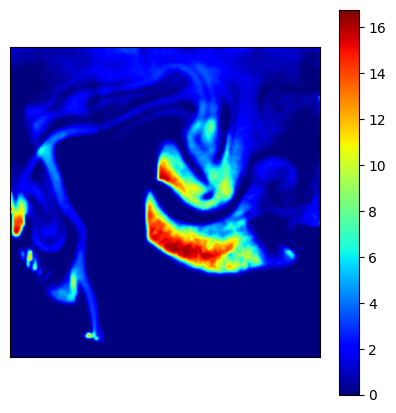

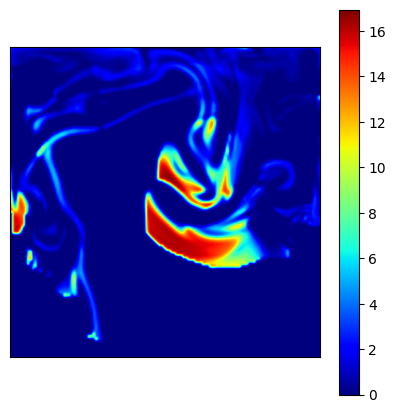

In [30]:
print(min_radVar1mc, max_radVar1mc)
percentile = False

getani(denorm_target_vars_nd['radVar1'], ns, dataset,'radVar1_data', min_radVar1mc, max_radVar1mc, percentile)
getani(denorm_target_vars_nd['radVar2'], ns, dataset,'radVar2_data', min_radVar2mc, max_radVar2mc, percentile)
 

In [31]:

# # Iterate over the variables and animate each one wanted
# getani(denorm_input_vars['no'], ns, dataset,'no',norm=False)
# getani(denorm_input_vars_nd['no'], ns, dataset,'nond',norm=False)

In [32]:
denorm_test_vars_nd = getdenorm(zdatand,test_results,'targets')
savemat("denorm_test_vars.mat", denorm_test_vars_nd)

min_radVar1nn = np.amin(denorm_test_vars_nd['radVar1'])
max_radVar1nn = np.amax(denorm_test_vars_nd['radVar1'])
min_radVar2nn = np.amin(denorm_test_vars_nd['radVar2']) 
max_radVar2nn = np.amax(denorm_test_vars_nd['radVar2'])

-5.6109773860130785 18.49044279942486
mean/stddev -0.007150334452703874 0.8167801769689096
mean/stddev 0.04253345039728633 1.012843678238401


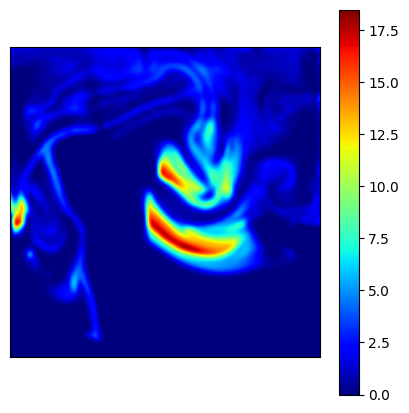

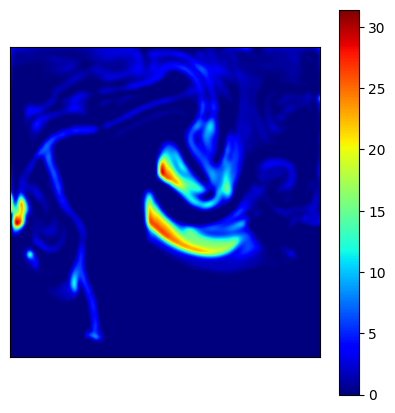

In [33]:

#Solution
print(min_radVar1nn, max_radVar1nn)
percentile = True

getani(denorm_test_vars_nd['radVar1'], ns, dataset,'radVar1_sol', min_radVar1nn, max_radVar1nn, percentile, norm=False)
getani(denorm_test_vars_nd['radVar2'], ns, dataset,'radVar2_sol', min_radVar2nn, max_radVar2nn, percentile, norm=False)


In [34]:
rv1ae = np.zeros((ns,nps,nps))
rv2ae = np.zeros((ns,nps,nps))
error_dict = {'radVar1': rv1ae, 'radVar2': rv2ae}

for i in range(ns):
    rv1ae[i,:,:] = np.abs(denorm_target_vars_nd['radVar1'][i,:,:] - denorm_test_vars_nd['radVar1'][i,:,:])
    rv2ae[i,:,:] = np.abs(denorm_target_vars_nd['radVar2'][i,:,:] - denorm_test_vars_nd['radVar2'][i,:,:])

min_rv1ae, max_rv1ae = np.amin(rv1ae), np.amax(rv1ae)
min_rv2ae, max_rv2ae = np.amin(rv2ae), np.amax(rv2ae)

savemat("rv1ae.mat", {"error" : error_dict['radVar1']})
savemat("rv2ae.mat", {"error" : error_dict['radVar2']})

In [35]:
error_dict['radVar1']

array([[[2.81200338e-02, 1.10711290e-02, 1.23729489e-03, ...,
         6.86140221e-03, 8.72579318e-03, 4.50132064e-02],
        [6.97015476e-03, 5.29326080e-02, 3.83639935e-02, ...,
         2.74525838e-02, 2.55648618e-02, 3.10336861e-02],
        [3.72791661e-03, 4.11291601e-02, 2.93571624e-02, ...,
         2.14605722e-02, 2.05401941e-02, 3.39893454e-02],
        ...,
        [1.12383376e-02, 8.17019932e-02, 8.57508220e-02, ...,
         1.42561305e-01, 2.28541718e-01, 5.31339052e-02],
        [6.12180681e-02, 1.87361799e-01, 1.94322206e-01, ...,
         1.85609675e-01, 2.72309564e-01, 9.85584798e-02],
        [8.09556236e-02, 9.24562091e-02, 8.24950169e-02, ...,
         1.29642191e-03, 7.26570665e-02, 8.19623607e-04]],

       [[2.81200617e-02, 1.10711000e-02, 1.23728276e-03, ...,
         6.86140139e-03, 8.72579245e-03, 4.50132062e-02],
        [6.97010031e-03, 5.29325567e-02, 3.83639743e-02, ...,
         2.74525863e-02, 2.55648641e-02, 3.10336853e-02],
        [3.72793350e-03, 

mean/stddev 0.11870363954864284 0.23225612760542902
mean/stddev 0.18432282300425312 0.35735666960996215


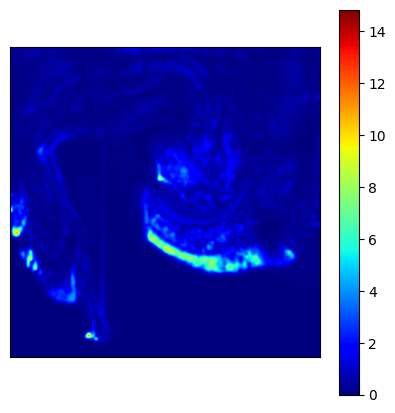

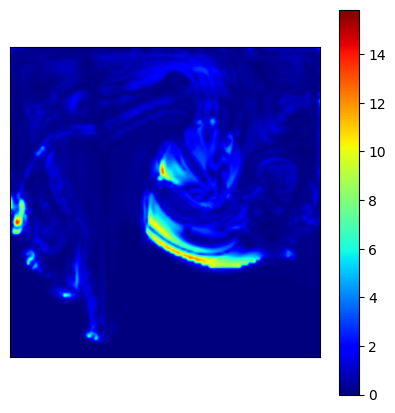

In [36]:

percentile = True
getani(error_dict['radVar1'], ns, dataset,'radVar1error', min_rv1ae, max_rv1ae, percentile, norm=False)
getani(error_dict['radVar2'], ns, dataset,'radVar2error', min_rv2ae, max_rv2ae, percentile, norm=False)

